https://www.lendingclub.com/


點對點借貸平台. 可申請3~5年無抵押的個人貸款, 投資者可以根據申請貸款者的信用條件、貸款期數或貸款金額等給予貸款者信用評等(A最好, G最差)。並核予貸款額度、貸款利率、貸款年限。而投資者可以賺取利息。而平台方收取服務費用。

```
id / member_id: Unique identifiers for each borrower or loan.
loan_amnt: The amount requested by the borrower.
funded_amnt / funded_amnt_inv: The amount actually funded for the loan.
term: The loan term (e.g., 36 months, 60 months).
int_rate: The interest rate of the loan.
installment: The monthly payment amount.
grade / sub_grade: The credit grade assigned to the borrower (e.g., A, B, C).
emp_title / emp_length: The borrower’s job title and the length of employment.
home_ownership: The borrower’s home ownership status (e.g., rent, own).
annual_inc: The borrower’s annual income.
verification_status: Indicates whether the income was verified.
loan_status: The current status of the loan (e.g., current, charged off).
purpose: The reason for taking out the loan (e.g., debt consolidation, home improvement).
zip_code: The borrower’s zip code.
addr_state: The state in which the borrower resides.
dti: Debt-to-income ratio.
delinq_2yrs: Number of delinquencies in the past two years.
earliest_cr_line: The date of the borrower’s earliest credit line.
inq_last_6mths: Number of inquiries in the last 6 months.
open_acc / total_acc: Number of open accounts and total accounts.
pub_rec: Number of public records (e.g., bankruptcies, liens).
revol_bal: Total revolving balance.
revol_util: Revolving line utilization rate.
total_pymnt / total_rec_prncp / total_rec_int: Payments made, principal received, interest received.

```


# Google Colab Setup
**Only for users on Google Colab**

In [1]:
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
connectDrive()

# Change path
changeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning/")

Mounted at /content/drive
Original path:  /content
New path:  /content/drive/My Drive/github/handson-unsupervised-learning


In [2]:
# Install additional libraries
!pip install fastcluster==1.1.26
!pip install hdbscan==0.8.27

# Import Libraries

In [20]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn import impute
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

# Load & Prepare Data

In [21]:
# Load the data
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'lending_club_data', 'LoanStats3a.csv'])
data = pd.read_csv(current_path + file, low_memory=False)

In [22]:
data.shape

(42542, 145)

In [23]:
# Select columns to keep
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

data = data.loc[:,columnsToKeep]

In [24]:
# View shape
data.shape

(42542, 37)

In [25]:
# Preview data
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30


In [26]:
# Transform features from string to numeric
for i in ["term","int_rate","emp_length","revol_util"]:
    data.loc[:,i] = \
        data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])

In [27]:
# Determine which features are numerical
numericalFeats = [x for x in data.columns if data[x].dtype != 'object']

In [39]:
data.loc[:,["term","int_rate","emp_length","revol_util"]]

,term,int_rate,emp_length,revol_util
0,36.000000,1065.000000,10.000000,8370.000000
1,60.000000,1527.000000,1.000000,940.000000
2,36.000000,1596.000000,10.000000,9850.000000
3,36.000000,1349.000000,10.000000,21.000000
4,60.000000,1269.000000,1.000000,5390.000000
...,...,...,...,...
42537,36.000000,775.000000,10.000000,4425.835363
42538,42.207218,1216.501563,5.045289,4425.835363
42539,42.207218,1216.501563,5.045289,4425.835363
42540,42.207218,1216.501563,5.045289,4425.835363


In [28]:
# Display NaNs by feature
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                      7
funded_amnt                    7
funded_amnt_inv                7
term                           7
int_rate                       7
installment                    7
emp_length                  1119
annual_inc                    11
dti                            7
delinq_2yrs                   36
mths_since_last_delinq     26933
mths_since_last_record     38891
open_acc                      36
pub_rec                       36
revol_bal                      7
revol_util                    97
total_acc                     36
out_prncp                      7
out_prncp_inv                  7
total_pymnt                    7
total_pymnt_inv                7
total_rec_prncp                7
total_rec_int                  7
total_rec_late_fee             7
recoveries                     7
collection_recovery_fee        7
last_pymnt_amnt                7
dtype: int64

In [29]:
# Impute NaNs with mean 
fillWithMean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# Impute NaNs with zero
fillWithZero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

# Perform imputation #Replace missing values using a descriptive statistic
#https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
#SimpleImputer(issing_values=nan, strategy='most_frequent', fill_value=None)

im = impute.SimpleImputer(strategy='mean')   
data.loc[:,fillWithMean] = im.fit_transform(data[fillWithMean])

data.loc[:,fillWithZero] = data.loc[:,fillWithZero].fillna(value=0,axis=1)

In [30]:
# Check for NaNs one last time
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

In [31]:
# Feature engineering
data['installmentOverLoanAmnt'] = data.installment/data.loan_amnt
data['loanAmntOverIncome'] = data.loan_amnt/data.annual_inc
data['revol_balOverIncome'] = data.revol_bal/data.annual_inc
data['totalPymntOverIncome'] = data.total_pymnt/data.annual_inc
data['totalPymntInvOverIncome'] = data.total_pymnt_inv/data.annual_inc
data['totalRecPrncpOverIncome'] = data.total_rec_prncp/data.annual_inc
data['totalRecIncOverIncome'] = data.total_rec_int/data.annual_inc

newFeats = ['installmentOverLoanAmnt','loanAmntOverIncome', \
            'revol_balOverIncome','totalPymntOverIncome', \
           'totalPymntInvOverIncome','totalRecPrncpOverIncome', \
            'totalRecIncOverIncome']

In [32]:
# Select features for training
numericalPlusNewFeats = numericalFeats+newFeats
X_train = data.loc[:,numericalPlusNewFeats]

# Scale data
sX = pp.StandardScaler()
X_train.loc[:,:] = sX.fit_transform(X_train)

In [33]:
# View columns
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'installmentOverLoanAmnt',
       'loanAmntOverIncome', 'revol_balOverIncome', 'totalPymntOverIncome',
       'totalPymntInvOverIncome', 'totalRecPrncpOverIncome',
       'totalRecIncOverIncome'],
      dtype='object')

In [34]:
# Designate labels for evaluation
labels = data.grade
labels.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G', nan], dtype=object)

In [35]:
# Fill missing labels
labels = labels.fillna(value="Z")

# Convert labels to numerical values
lbl = pp.LabelEncoder()
lbl.fit(list(labels.values))
labels = pd.Series(data=lbl.transform(labels.values), name="grade")

# Store as y_train
y_train = labels

In [36]:
# Show numerical labels
labelsOriginalVSNew = pd.concat([labels, data.grade],axis=1)
labelsOriginalVSNew

,grade,grade
0,1,B
1,2,C
2,2,C
3,2,C
4,1,B
...,...,...
42537,0,A
42538,7,NaN
42539,7,NaN
42540,7,NaN


In [38]:
# Compare loan grades with interest rates
# 信用評等愈高, 平均貸款利率應愈低
interestAndGrade = pd.DataFrame(data=[data.int_rate,labels])
interestAndGrade = interestAndGrade.T

interestAndGrade.groupby("grade").mean()

,int_rate
grade,
0.0,734.270844
1.0,1101.420857
2.0,1349.988902
3.0,1557.714927
4.0,1737.676783
5.0,1926.530361
6.0,2045.125000
7.0,1216.501563


In [43]:
X_train.loc[:,["int_rate"]]

,int_rate
0,-0.408626
1,0.837468
2,1.023573
3,0.357371
4,0.141597
...,...
42537,-1.190806
42538,0.000000
42539,0.000000
42540,0.000000


# Define Function
```
分在同一群的信用評等應該都是相近的.
量化分數:

(1) 群裡的相近度= 該群內評等出現最多次的數量/ 該群的總數量
       此數值愈高, 表示群裡的同質性愈高
       
(2) 整體的相似度: 所有群內評等出現最多次的數量/ 所有群的總數量
    
```


In [62]:
# To Analyze Goodness of the Clusters
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg( \
        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
        left_on="cluster",right_on="cluster")
    
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, \
        accuracyDF, overallAccuracy, accuracyByLabel

# Dimensionality Reduction

In [47]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 34
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

In [48]:
 # Log data
from sklearn.utils import resample
cwd = os.getcwd()
log_dir = cwd+"/logs/06_group_segmentation/"
sample = resample(y_train,replace=False,n_samples=2000,random_state=2021,stratify=y_train)
sample.to_csv(log_dir+'labels.tsv', sep = '\t', index=False, header=False)

In [49]:
# Write dimensions to CSV
X_train_PCA.loc[sample.index,0:3].to_csv(log_dir+'pca_data.tsv', sep = '\t', index=False, header=False)

# K-means Application

In [50]:
# Apply K-Means
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, \
                random_state=random_state)

kMeans_inertia = pd.DataFrame(data=[],index=range(10,31), \
                              columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[], \
    index=range(10,31),columns=['overallAccuracy'])

for n_clusters in range(10,31):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                    max_iter=max_iter, tol=tol, \
                    random_state=random_state)

    kmeans.fit(X_train_PCA)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA)
    X_train_kmeansClustered = pd.DataFrame(data= \
        X_train_kmeansClustered, index=X_train.index, \
        columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, \
    countMostFreq_kMeans, accuracyDF_kMeans, \
    overallAccuracy_kMeans, accuracyByLabel_kMeans = \
    analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = \
        overallAccuracy_kMeans

In [52]:
clusterDF=X_train_kmeansClustered
labelsDF=y_train

In [54]:
labelsDF

0        1
1        2
2        2
3        2
4        1
        ..
42537    0
42538    7
42539    7
42540    7
42541    7
Name: grade, Length: 42542, dtype: int32

In [53]:
clusterDF

,cluster
0,4
1,10
2,29
3,20
4,10
...,...
42537,28
42538,9
42539,9
42540,9


In [55]:
# To Analyze Goodness of the Clusters
countByCluster = \
    pd.DataFrame(data=clusterDF['cluster'].value_counts())
countByCluster.reset_index(inplace=True,drop=False)
countByCluster.columns = ['cluster','clusterCount']

preds = pd.concat([labelsDF,clusterDF], axis=1)
preds.columns = ['trueLabel','cluster']

countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())

countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg( \
    lambda x:x.value_counts().iloc[0]))
countMostFreq.reset_index(inplace=True,drop=False)
countMostFreq.columns = ['cluster','countMostFrequent']

accuracyDF = countMostFreq.merge(countByCluster, \
    left_on="cluster",right_on="cluster")

overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
    accuracyDF.clusterCount.sum()

accuracyByLabel = accuracyDF.countMostFrequent/ \
    accuracyDF.clusterCount


In [56]:
countByCluster #各群內的資料筆數

,cluster,clusterCount
0,28,3878
1,29,3207
2,9,2687
3,4,2662
4,10,2614
5,3,2609
6,6,2598
7,7,2537
8,12,2523
9,26,2077


In [58]:
countMostFreq #各群內同出現最多次的grade的數量
  

,cluster,countMostFrequent
0,0,241
1,1,274
2,2,647
3,3,901
4,4,1336
5,5,182
6,6,1295
7,7,852
8,8,6
9,9,1801


In [59]:
accuracyDF

,cluster,countMostFrequent,clusterCount
0,0,241,838
1,1,274,1135
2,2,647,1617
3,3,901,2609
4,4,1336,2662
5,5,182,699
6,6,1295,2598
7,7,852,2537
8,8,6,20
9,9,1801,2687


In [61]:
accuracyByLabel

0     0.287589
1     0.241410
2     0.400124
3     0.345343
4     0.501878
5     0.260372
6     0.498460
7     0.335830
8     0.300000
9     0.670264
10    0.270084
11    0.376268
12    0.346809
13    0.371521
14    0.263339
15    0.297619
16    0.229263
17    0.214953
18    0.250000
19    0.272487
20    0.312651
21    0.243781
22    0.327630
23    0.307832
24    0.500000
25    0.319608
26    0.326432
27    0.189655
28    0.562919
29    0.323043
dtype: float64

In [60]:
overallAccuracy

0.3843025715763246

In [57]:
countByLabel #y grade level ,A~G的數量

,cluster
trueLabel,
0,10183
1,12389
2,8740
3,6016
4,3394
5,1301
6,512
7,7


<Axes: >

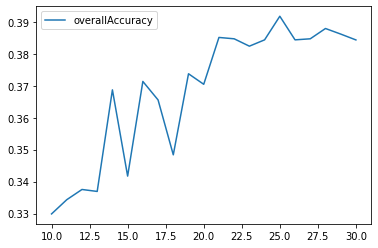

In [51]:
# View plot
#當10~30群,分別觀察其 OverallAccuracy.
#K=30群, 整體而言，各群的同質性是最高的
overallAccuracy_kMeansDF.plot()

In [64]:
# View accuracy by cluster
accuracyByLabel_kMeans

0     0.287589
1     0.241410
2     0.400124
3     0.345343
4     0.501878
5     0.260372
6     0.498460
7     0.335830
8     0.300000
9     0.670264
10    0.270084
11    0.376268
12    0.346809
13    0.371521
14    0.263339
15    0.297619
16    0.229263
17    0.214953
18    0.250000
19    0.272487
20    0.312651
21    0.243781
22    0.327630
23    0.307832
24    0.500000
25    0.319608
26    0.326432
27    0.189655
28    0.562919
29    0.323043
dtype: float64

In [27]:
# Save cluster labels
X_train_kmeansClustered.loc[sample.index].to_csv(log_dir+'kmeans_cluster_labels.tsv', sep = '\t', index=False, header=False)

# Hierarchical Clustering Application


clusterOne, clusterTwo 槾位裡的值是群的編號,表示那個群的編號和那個群的編號要合併, 合併後的群會產生新的群編號。
clusterOne, clusterTwo
85076.0	     85081.0   進行合併??

資料原本為 (42542, 34), 怎麼有群組編號85081?
0~42541 是原本的資料, 而42542的組編號後是的來自合併的新群編號。

In [68]:
# Hierarchical Clustering Application
import fastcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = fastcluster.linkage_vector(X_train_PCA, method='ward', \
                               metric='euclidean')

Z_dataFrame = pd.DataFrame(data=Z,columns=['clusterOne', \
                'clusterTwo','distance','newClusterSize'])

In [69]:
X_train_PCA.shape

(42542, 34)

In [70]:
# View bottom most leaves



Z_dataFrame[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,39786.0,39787.0,0.000000e+00,2.0
1,39788.0,42542.0,0.000000e+00,3.0
2,42539.0,42540.0,0.000000e+00,2.0
3,42541.0,42544.0,1.799039e-16,3.0
4,42538.0,42543.0,2.096147e-16,4.0
5,42545.0,42546.0,3.639077e-16,7.0
6,33251.0,33261.0,1.561313e-01,2.0
7,42512.0,42535.0,3.342654e-01,2.0
8,42219.0,42316.0,3.368231e-01,2.0
9,6112.0,21928.0,3.384368e-01,2.0


In [71]:
# View top most leaves
Z_dataFrame[42521:]

,clusterOne,clusterTwo,distance,newClusterSize
42521,85038.0,85043.0,132.715723,3969.0
42522,85051.0,85052.0,141.386569,2899.0
42523,85026.0,85027.0,146.976703,2351.0
42524,85048.0,85049.0,152.660192,5691.0
42525,85036.0,85059.0,153.512281,5956.0
42526,85033.0,85044.0,160.825959,2203.0
42527,85055.0,85061.0,163.701428,668.0
42528,85062.0,85066.0,168.199295,6897.0
42529,85054.0,85060.0,168.924039,9414.0
42530,85028.0,85064.0,185.215769,3118.0


In [31]:
# Cluster results
from scipy.cluster.hierarchy import fcluster

distance_threshold = 100
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = pd.DataFrame(data=clusters, \
    index=X_train.index,columns=['cluster'])

In [32]:
# Show number of clusters created
print("Number of distinct clusters: ", \
      len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  32


In [33]:
# Show overall accuracy
countByCluster_hierClust, countByLabel_hierClust, \
    countMostFreq_hierClust, accuracyDF_hierClust, \
    overallAccuracy_hierClust, accuracyByLabel_hierClust = \
    analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ", \
      overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.3651685393258427


In [34]:
# Show accuracy by cluster
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.304124
1     0.219001
2     0.228311
3     0.379722
4     0.240064
5     0.272011
6     0.314560
7     0.263930
8     0.246138
9     0.318942
10    0.302752
11    0.269772
12    0.335717
13    0.330403
14    0.346320
15    0.440141
16    0.744155
17    0.502227
18    0.294118
19    0.236111
20    0.254727
21    0.241042
22    0.317979
23    0.308771
24    0.284314
25    0.243243
26    0.500000
27    0.289157
28    0.365283
29    0.479693
30    0.393559
31    0.340875
dtype: float64

In [35]:
# Save cluster labels
X_train_hierClustered.loc[sample.index].to_csv(log_dir+'hierarchical_cluster_labels.tsv', sep = '\t', index=False, header=False)

# HDBSCAN Application

In [36]:
# HDBSCAN Application
import hdbscan

min_cluster_size = 20
min_samples = 20
alpha = 1.0
cluster_selection_method = 'leaf'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
    min_samples=min_samples, alpha=alpha, \
    cluster_selection_method=cluster_selection_method)

X_train_hdbscanClustered = hdb.fit_predict(X_train_PCA)
X_train_hdbscanClustered = pd.DataFrame(data= \
    X_train_hdbscanClustered, index=X_train.index, \
    columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan = \
    analyzeCluster(X_train_hdbscanClustered, y_train)

In [37]:
# Show overall accuracy
print("Overall accuracy from HDBSCAN: ", overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.3258426966292135


In [38]:
# Count by cluster
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,32478
1,6,4261
2,2,3668
3,1,1096
4,4,786
5,0,120
6,7,72
7,3,38
8,5,23


In [39]:
# Accuracy by cluster
accuracyByLabel_hdbscan

0    0.284346
1    0.341667
2    0.414234
3    0.332061
4    0.552632
5    0.438931
6    0.391304
7    0.588829
8    0.416667
dtype: float64

In [40]:
# Save cluster labels
X_train_hdbscanClustered.loc[sample.index].to_csv(log_dir+'hdbscan_cluster_labels.tsv', sep = '\t', index=False, header=False)

# Conclusion

In [41]:
import datetime as dt
print("Completed: ", dt.datetime.now())

Completed:  2021-05-05 19:45:41.336670
